<a href="https://colab.research.google.com/github/ValentinoRyo10/Machine-Learning/blob/main/CareerMatch_MLmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EXPLORATORY DATA ANALYSIS**

*DOWNLOAD DATASET*

In [2]:
# Install Kaggle library
!pip install kaggle

# Upload kaggle.json (API token file)
from google.colab import files
print("Upload kaggle.json file (API token)")
files.upload()

# Create a directory for Kaggle and move kaggle.json there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

# Download the Google Job Skills dataset from Kaggle
!kaggle datasets download -d niyamatalmass/google-job-skills

# Extract the dataset
import zipfile

with zipfile.ZipFile("google-job-skills.zip", 'r') as zip_ref:
    zip_ref.extractall("google_job_skills")

# List extracted files
import os
os.listdir("google_job_skills")


Upload kaggle.json file (API token)


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/niyamatalmass/google-job-skills
License(s): CC-BY-NC-SA-4.0
  0% 0.00/407k [00:00<?, ?B/s]
100% 407k/407k [00:00<00:00, 101MB/s]


['job_skills.csv']

---

*IMPORT LIBRARY*

In [16]:
# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from sklearn.feature_extraction.text import TfidfVectorizer

# Label encoding and splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Model building
import tensorflow as tf
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout #type: ignore
from collections import Counter
import nltk
nltk.download('punkt')

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Similarity calculation
from scipy.spatial.distance import cosine

# General utilities
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


*IMPORT DATASET*

In [14]:
data = pd.read_csv('/content/google_job_skills/job_skills.csv')
data.head()

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin..."
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...
3,Google,"Developer Advocate, Partner Engineering",Developer Relations,"Mountain View, CA, United States","Work one-on-one with the top Android, iOS, and...",BA/BS degree in Computer Science or equivalent...,"Experience as a software developer, architect,..."
4,Google,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Sunnyvale, CA, United States",Plan requirements with internal customers.\nPr...,BA/BS degree or equivalent practical experienc...,CTS Certification.\nExperience in the construc...


In [18]:
data.rename(columns={'Category': 'Job'}, inplace=True)

In [19]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Company                   1250 non-null   object
 1   Title                     1250 non-null   object
 2   Job                       1250 non-null   object
 3   Location                  1250 non-null   object
 4   Responsibilities          1235 non-null   object
 5   Minimum Qualifications    1236 non-null   object
 6   Preferred Qualifications  1236 non-null   object
dtypes: object(7)
memory usage: 68.5+ KB
None


In [20]:
for col in data.select_dtypes(include=['category', 'object']):
    print(f"\nColumn: {col}")
    print(data[col].value_counts())


Column: Company
Company
Google     1227
YouTube      23
Name: count, dtype: int64

Column: Title
Title
Business Intern 2018                                                              35
MBA Intern, Summer 2018                                                           34
MBA Intern 2018                                                                   28
BOLD Intern, Summer 2018                                                          21
Field Sales Representative, Google Cloud                                          17
                                                                                  ..
Enterprise Customer Development Representative, Google Cloud (Nordics)             1
Strategic Agency Consultant (Switzerland, Austria), Google Marketing Solutions     1
Data Analyst, Trust and Safety                                                     1
Account Strategist (English, Portuguese)                                           1
Facilities Manager                            

In [26]:
# Definisikan fungsi untuk mengelompokkan pekerjaan
def categorize_job(job):
    if job in ['Sales & Account Management', 'Sales Operations', 'Partnerships']:
        return 'Sales and Marketing'
    elif job in ['Finance', 'Business Strategy', 'Program Management']:
        return 'Finance and Business Strategy'
    elif job in ['Software Engineering','IT & Data Management', 'Developer Relations']:
        return 'Software Development and IT Services'
    elif job in ['Hardware Engineering', 'Technical Solutions', 'Technical Infrastructure', 'Network Engineering', 'Data Center & Network']:
        return 'Hardware Engineering and Infrastructure'
    elif job in ['Product & Customer Support', 'Administrative', 'People Operations', 'Manufacturing & Supply Chain','Real Estate & Workplace Services']:
        return 'Operations and Support'
    elif job in ['User Experience & Design', 'Technical Writing']:
        return 'Design and User Experience'
    elif job in ['Legal & Government Relations', 'Marketing & Communications']:
        return 'Legal and Communications'
    else:
        return 'Other'  # Untuk Job yang tidak terkategorisasi

# Menambahkan kolom 'Category'
data['Category'] = data['Job'].apply(categorize_job)

# Meletakkan kolom 'Category' di paling kanan
data = data[[col for col in data.columns if col != 'Category'] + ['Category']]

# Menampilkan beberapa baris untuk memverifikasi
data.head()


,Company,Title,Job,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications,Category
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...,Finance and Business Strategy
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin...",Operations and Support
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...,Hardware Engineering and Infrastructure
3,Google,"Developer Advocate, Partner Engineering",Developer Relations,"Mountain View, CA, United States","Work one-on-one with the top Android, iOS, and...",BA/BS degree in Computer Science or equivalent...,"Experience as a software developer, architect,...",Software Development and IT Services
4,Google,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Sunnyvale, CA, United States",Plan requirements with internal customers.\nPr...,BA/BS degree or equivalent practical experienc...,CTS Certification.\nExperience in the construc...,Finance and Business Strategy


*DATA VISUALIZATION*

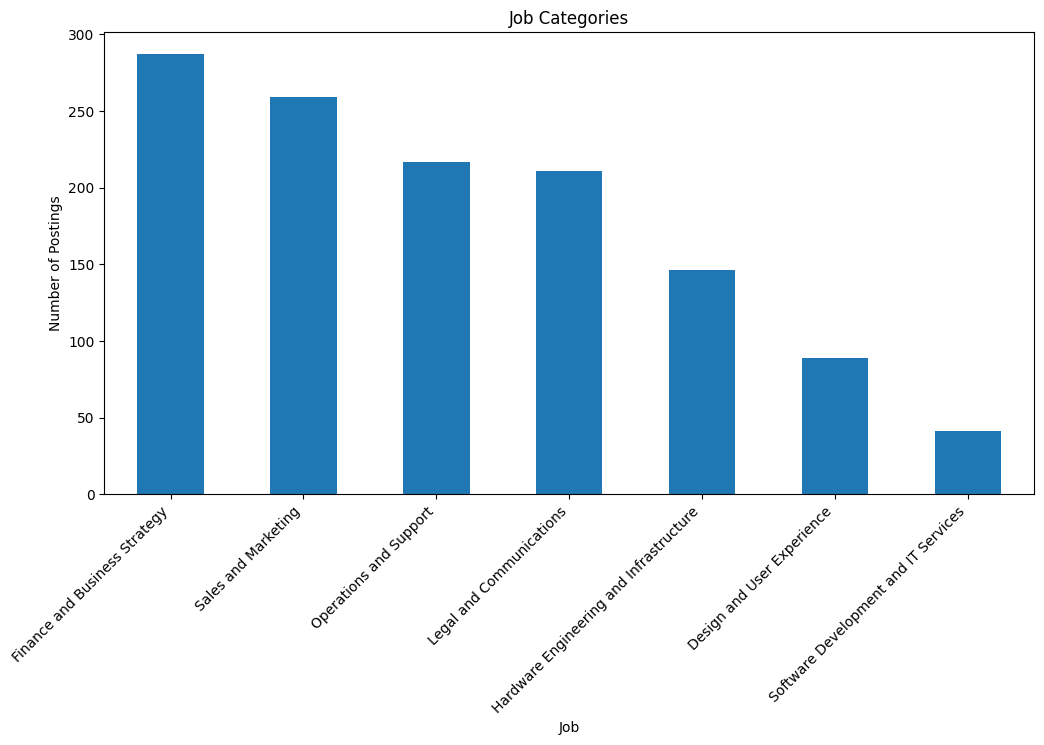

In [28]:
# Distribution of Job Categories
plt.figure(figsize=(12, 6))
data['Category'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Job Categories')
plt.xlabel('Job')
plt.ylabel('Number of Postings')
plt.xticks(rotation=45, ha='right')
plt.show()